In [1]:
#! pip install tensorflow opencv-pythons

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import AdamW
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Set random seed for reproducibility
np.random.seed(42)


c:\Users\mayan\anaconda3\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

# Path to your dataset
dataset_dir = 'Indian'

# Image size (adjust as needed based on your images)
img_height, img_width = 64, 64
batch_size = 32

# Data augmentation and rescaling (for training)
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values (0-255) to (0-1)
    validation_split=0.2      # Reserve 20% of the images for validation
)


In [4]:
# Load training data
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',   # Use 'rgb' if your images are in color
    batch_size=batch_size,
    class_mode='categorical', # Since you have multiple classes (A-Z, 1-9)
    subset='training',        # Set this as training data
    shuffle=True
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'       # Set this as validation data
)

Found 34198 images belonging to 35 classes.
Found 8547 images belonging to 35 classes.


In [7]:
# Check the class indices (this will map folders to labels)
print(train_generator.class_indices)

# Check the shape of the images (batch_size, img_height, img_width, channels)

x, y = next(train_generator)
print(x.shape)
print(y.shape)
for x_batch, y_batch in train_generator:
    print(x_batch.shape)
    print(y_batch.shape)
    break  # Just to check the first batch, remove break to iterate through more batches



{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}
(32, 64, 64, 1)
(32, 35)
(32, 64, 64, 1)
(32, 35)


In [13]:
# Model definition
model = Sequential()

# Convolutional layers with Dropout and Batch Normalization
# Update input_shape to (64, 64, 1) to match your image size
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers with higher dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Higher dropout to prevent overfitting

# Adjust the number of classes to 35 (for A-Z and 1-9)
model.add(Dense(35, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Compile the model with a custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 35)             │         8,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282,467 (4.89 MB)

 Trainable params: 1,282,019 (4.89 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 650s 600ms/step - accuracy: 0.8378 - loss: 0.7278 - val_accuracy: 0.9760 - val_loss: 0.4333
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 312s 291ms/step - accuracy: 0.9856 - loss: 0.0514 - val_accuracy: 0.9731 - val_loss: 0.5080
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 247s 230ms/step - accuracy: 0.9891 - loss: 0.0495 - val_accuracy: 0.9825 - val_loss: 0.8036
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 245s 229ms/step - accuracy: 0.9910 - loss: 0.0473 - val_accuracy: 0.9814 - val_loss: 0.4900
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 238s 222ms/step - accuracy: 0.9944 - loss: 0.0300 - val_accuracy: 0.9750 - val_loss: 0.8775
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 237s 222ms/step - accuracy: 0.9947 - loss: 0.0308 - val_accuracy: 0.9768 - val_loss: 0.9324
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 235s 220ms/step - accuracy: 0.9969 - loss: 0.0186 - val_accuracy: 0.9822 - val_loss: 1.0215
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 217s 203ms/step - ac

In [15]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.9849 - loss: 0.9342
Validation Accuracy: 98.53%


In [6]:
# Save the trained model
model.save('sign_language_model.h5')
print("Model saved as 'sign_language_model.h5'")


268/268 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.9800 - loss: 0.1966


Validation Accuracy: 98.01%
Model saved as 'sign_language_model.h5'


268/268 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step


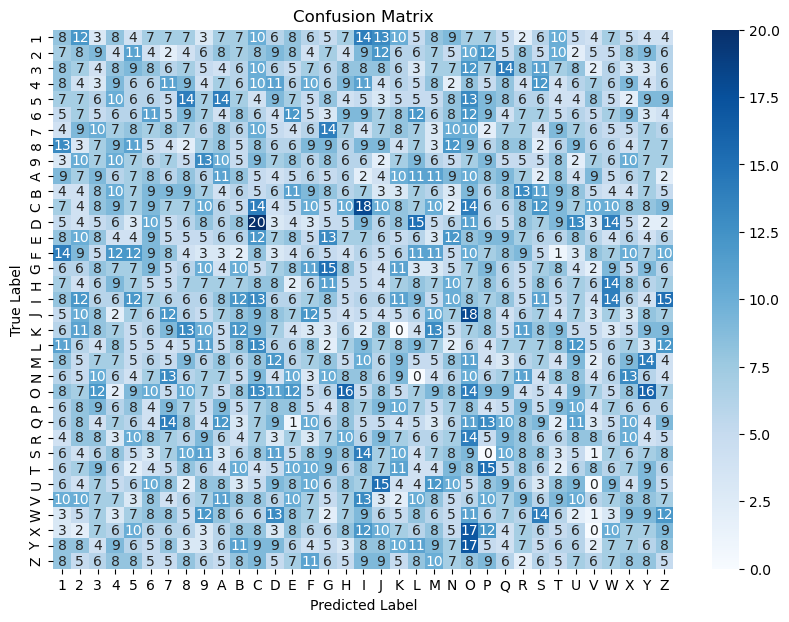

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  
# Predict the labels for validation data
y_true = validation_generator.classes  # True labels
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to label indices

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
import cv2

def detect_hand(image):
    # Load pre-trained hand detector (use OpenCV's Haar cascades or a more advanced model)
    hand_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'hand.xml')  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hands = hand_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in hands:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    return image

# You can integrate this function into your data preprocessing pipeline.




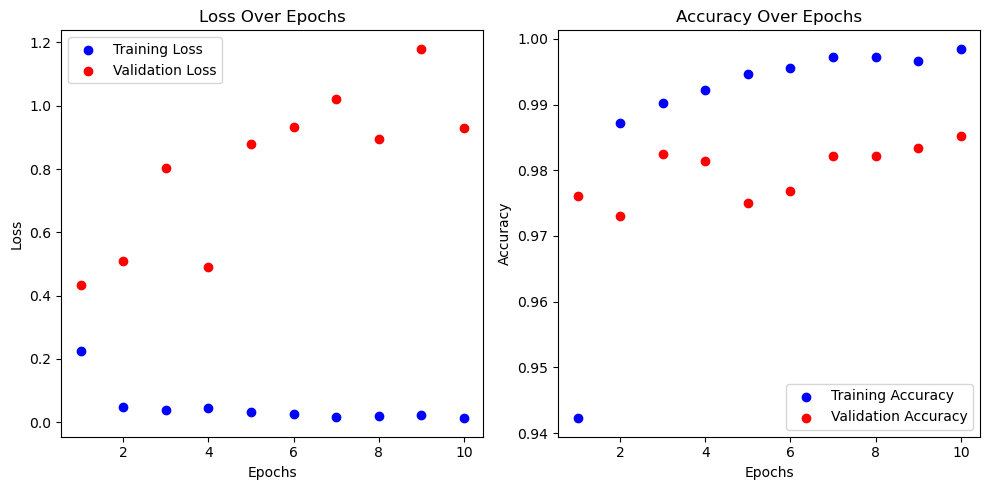

In [17]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a scatter plot for Loss
plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.scatter(range(1, len(train_loss) + 1), train_loss, color='blue', label='Training Loss')
plt.scatter(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.scatter(range(1, len(train_accuracy) + 1), train_accuracy, color='blue', label='Training Accuracy')
plt.scatter(range(1, len(val_accuracy) + 1), val_accuracy, color='red', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk

# Load your pre-trained model (ensure the model is in the correct path)
model = tf.keras.models.load_model("sign_language_model.h5")

# Define class labels (adjust according to your model's output)
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Function to preprocess frames before prediction
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    frame = cv2.resize(frame, (64, 64))  # Resize to match the input size of your model
    frame = img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    frame /= 255.0  # Normalize pixel values
    return frame

# Function to show camera feed and predict sign language
def show_frame():
    _, frame = cap.read()
    
    # Preprocess the frame for model prediction
    processed_frame = preprocess_frame(frame)
    
    # Predict the sign language gesture
    prediction = model.predict(processed_frame)
    predicted_class = np.argmax(prediction, axis=1)  # Get the predicted class index
    predicted_label = class_labels[predicted_class[0]]  # Map the index to the label
    
    # Display the prediction on the camera feed
    cv2.putText(frame, f"Sign: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
    # Convert the frame to an image that Tkinter can display
    cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    img = Image.fromarray(cv2image)
    imgtk = ImageTk.PhotoImage(image=img)
    lbl.imgtk = imgtk
    lbl.configure(image=imgtk)
    lbl.after(10, show_frame)

# Initialize the camera feed
cap = cv2.VideoCapture(0)

# Set up the Tkinter window
window = tk.Tk()
window.title("Sign Language Detection")

lbl = tk.Label(window)
lbl.pack()

# Start the camera feed and prediction loop
show_frame()

# Run the Tkinter event loop
window.mainloop()

# Release the camera once the window is closed
cap.release()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

In [6]:
model = Sequential()

# Convolutional layers with Dropout and Batch Normalization
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

# Fully connected layers with higher dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))  # Higher dropout to prevent overfitting
model.add(Dense(25, activation='softmax'))


c:\Users\mayan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
